In [1]:
# INSPECT TRAINED MODEL
# Load libraries
import os
import json
import random
from random import randint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
from sklearn import preprocessing
from skimage.measure import find_contours
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
DATA_DIR = "/media/daitran/Data/Kaggle/VinBigData"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/'
resized_test_folder = '/home/daitran/Desktop/research/kaggle/VinBigData/test/'

orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

# Load training dataframe .csv
training_df = pd.read_csv('/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/sample_df.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})
samples_df = training_df

In [3]:
# CONFIGURATIONS
from mrcnn.config import Config
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

NUM_CATS = 14
IMAGE_SIZE = 512

In [4]:
# Create Config 
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 10 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7


    STEPS_PER_EPOCH = int(len(samples_df)*0.8/IMAGES_PER_GPU)
    VALIDATION_STEPS = int(len(samples_df)/IMAGES_PER_GPU)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()

In [5]:
# Create Inference Config
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [6]:
# Extract class names
category_list = orin_df.class_name.unique()

In [7]:
# Create Mask RCNN formart dataset
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".jpg",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'],
                           img_org_id = row.image_id)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

In [8]:
# Load dataset
# Split with train = 80% samples and val = 10% and test = 10%
training_percentage = 0.8

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((0.9-training_percentage)*len(samples_df))
test_set_size = int((0.9-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

test_dataset = DiagnosticDataset(samples_df[training_set_size + validation_set_size:])
test_dataset.prepare()


In [9]:
# Show validation dataset information
print("Images: {}\nClasses: {}".format(len(valid_dataset.image_ids), valid_dataset.class_names))

Images: 3609
Classes: ['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']


In [10]:
k= 0
for class_name in valid_dataset.class_names:
    print(k)
    print(class_name)
    k +=1
# print(valid_dataset.class_names)

0
BG
1
Cardiomegaly
2
Aortic enlargement
3
Pleural thickening
4
ILD
5
Nodule/Mass
6
Pulmonary fibrosis
7
Lung Opacity
8
Atelectasis
9
Other lesion
10
Infiltration
11
Pleural effusion
12
Calcification
13
Consolidation
14
Pneumothorax


## BG = Background!!!!

In [11]:
# Call model
model = modellib.MaskRCNN(mode="inference", model_dir="",
                              config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
# Pretrained weight
model_path = '/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/server_weights/mask_rcnn_diagnostic_0025.h5'
model.load_weights(model_path, by_name=True)

In [24]:
# Display original
def display_test_result(dataset):
    image_id = random.choice(dataset.image_ids)
#     print(image_id)
#     print(dataset.class_names)

    # Display original Dicom

    # plot_bbox(img_id = dataset.image_info[image_id]['img_org_id'])

    # Display original in training form

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               image_id, use_mini_mask=False)

#     log("original_image", original_image)
#     log("image_meta", image_meta)
#     log("gt_class_id", gt_class_id)
#     log("gt_bbox", gt_bbox)
#     log("gt_mask", gt_mask)
    
    print('GT')
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, figsize=(5, 5))
    print(gt_class_id)
    
    # Display test prediction

    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    print('Predict')
    print(r['class_ids'])
    print(r['scores'])
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], figsize=(5, 5))

In [25]:
train_dataset.class_names

['BG',
 'Cardiomegaly',
 'Aortic enlargement',
 'Pleural thickening',
 'ILD',
 'Nodule/Mass',
 'Pulmonary fibrosis',
 'Lung Opacity',
 'Atelectasis',
 'Other lesion',
 'Infiltration',
 'Pleural effusion',
 'Calcification',
 'Consolidation',
 'Pneumothorax']

GT


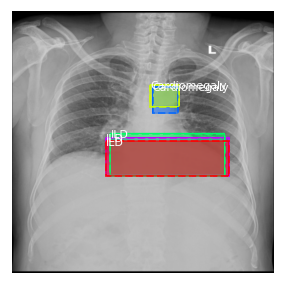

[4 4 1 4 1]
Predict
[4 1]
[0.99837863 0.98465157]


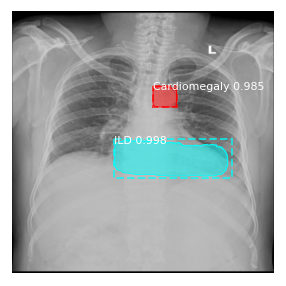

In [29]:
for _ in range(1):
    display_test_result(dataset = test_dataset)

## Generate submission.csv

In [30]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

In [31]:
selected_classes_dict = {"0":14,"1":3,"2":0,"3":11,"4":5,"5":8,"6":13,"7":7,
                         "8":1,"9":9,"10":6,"11":10,"12":2,"13":4,"14":12}


In [32]:
selected_classes_dict

{'0': 14,
 '1': 3,
 '2': 0,
 '3': 11,
 '4': 5,
 '5': 8,
 '6': 13,
 '7': 7,
 '8': 1,
 '9': 9,
 '10': 6,
 '11': 10,
 '12': 2,
 '13': 4,
 '14': 12}

In [33]:
def find_anomalies(dicom_image):

    image_dimensions = dicom_image.shape

    resized_img = cv2.resize(dicom_image, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
    saved_filename = resized_test_folder+"temp_image.jpg"
    
    cv2.imwrite(saved_filename, resized_img) 
    img = cv2.imread(saved_filename)

    result = model.detect([img])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
#         masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    return rois, r['class_ids'], r['scores']

In [ ]:
results = []
test_file_list = os.listdir(TEST_DIR)

# Convert predict to original class id
# selected_classes_dict = {"0":14,"1":2,"2":0,"3":11,"4":5,"5":8,"6":13,"7":7,
#                          "8":1,"9":9,"10":6,"11":10,"12":2,"13":4,"14":12}

for image_file_name in tqdm(test_file_list):
    
    dicom_image = dicom2array(TEST_DIR + '/' + image_file_name)
    image_dimensions = dicom_image.shape
    
    # extracrt results
    bbox_list, class_list, confidence_list = find_anomalies(dicom_image)
    
#     print(class_list)
#     # convert from single-channel grayscale to 3-channel RGB
#     img = np.stack([dicom_image] * 3, axis=2)
#     resized_img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
    
#     # visualize
#     result = model.detect([resized_img])
#     r = result[0]
    
#     visualize.display_instances(resized_img, r['rois'], r['masks'], r['class_ids'], 
#                                 train_dataset.class_names, r['scores'], show_mask = True,
#                                figsize=(5,5))
    
    # found abnormalities
    
    prediction_string = ""
    
    if len(bbox_list) > 0:
        
        for bbox, class_id, confidence in zip(bbox_list, class_list, confidence_list):
            
            # Convert to submission class id
            for key, value in selected_classes_dict.items():
                if class_id == int(key):
                    class_id_correct = value
            
#             print(class_id_correct)
            confidence_score = str(round(confidence,3))
            
#             y_scale = image_dimensions[0]/IMAGE_SIZE
#             x_scale = image_dimensions[1]/IMAGE_SIZE
            rescaled_bbox = (bbox * [1, 1, 1, 1]).astype(int)
            
    
            #organise the bbox into xmin, ymin, xmax, ymax
            ymin = image_dimensions[0]-rescaled_bbox[2]
            ymax = image_dimensions[0]-rescaled_bbox[0]
            xmin = rescaled_bbox[1]
            xmax = rescaled_bbox[3]
            
            prediction_string += "{} {} {} {} {} {} ".format(class_id_correct, confidence_score, xmin, ymin, xmax, ymax)
            
        results.append({"image_id":image_file_name.replace(".dicom",""), "PredictionString":prediction_string.strip()})
        
    else:
        results.append({"image_id":image_file_name.replace(".dicom",""), "PredictionString":"14 1 0 0 1 1"})
submission_df = pd.DataFrame(results)

  1%|          | 34/3000 [00:19<28:54,  1.71it/s]

In [ ]:
submission_df